In [10]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, transf_chik_pred
from pgbm_model import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 
import matplotlib.dates as mdates
from plots_pgbm import predicted_vs_observed as p_o_pgbm
from plots_lstm import predicted_vs_observed as p_o_lstm
fmt = mdates.DateFormatter('%d-%b\n%Y')

In [11]:
CITY = 2304400
CITY_NAME = 'Fortaleza'
STATE = 'CE'
FILENAME_DATA = f'../../data/chik_{CITY}_cluster.csv'

In [12]:
df_chik = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2304400,casos_est_2304400,casos_est_min_2304400,casos_est_max_2304400,p_rt1_2304400,p_inc100k_2304400,temp_min_2304400,temp_max_2304400,umid_min_2304400,pressao_min_2304400,...,casos_2306306,casos_est_2306306,casos_est_min_2306306,casos_est_max_2306306,p_rt1_2306306,p_inc100k_2306306,temp_min_2306306,temp_max_2306306,umid_min_2306306,pressao_min_2306306
2010-01-03,0,0.0,0,0,0.000000,0.000000,23.333333,28.333333,66.333333,1009.000000,...,0,0.0,0,0,0.000000,0.00000,23.333333,28.333333,66.333333,1009.000000
2010-01-10,0,0.0,0,0,0.000000,0.000000,24.714286,29.714286,59.571429,1009.428571,...,0,0.0,0,0,0.000000,0.00000,24.714286,29.714286,59.571429,1009.428571
2010-01-17,0,0.0,0,0,0.000000,0.000000,25.142857,30.571429,58.142857,1010.714286,...,0,0.0,0,0,0.000000,0.00000,25.142857,30.571429,58.142857,1010.714286
2010-01-24,0,0.0,0,0,0.000000,0.000000,24.714286,30.857143,54.142857,1009.000000,...,0,0.0,0,0,0.000000,0.00000,24.714286,30.857143,54.142857,1009.000000
2010-01-31,0,0.0,0,0,0.000000,0.000000,24.714286,30.571429,61.428571,1007.857143,...,0,0.0,0,0,0.000000,0.00000,24.714286,30.571429,61.428571,1007.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27,22,27.0,22,38,0.057999,1.004983,26.142857,29.857143,61.059517,1009.142857,...,0,0.0,0,0,0.000000,0.00000,26.142857,29.857143,61.059517,1009.142857
2022-12-04,13,19.0,14,32,0.018656,0.707210,26.142857,30.285714,58.965531,1006.714286,...,2,2.0,2,2,0.859816,3.76882,26.142857,30.285714,58.965531,1006.714286
2022-12-11,12,21.0,14,44,0.203211,0.781654,26.000000,31.000000,58.365561,1009.285714,...,0,0.0,0,0,0.000000,0.00000,26.000000,31.000000,58.365561,1009.285714
2022-12-18,9,23.0,12,57,0.542593,0.856097,26.166667,30.333333,60.203788,1009.333333,...,0,0.0,0,0,0.000000,0.00000,26.166667,30.333333,60.203788,1009.333333


In [4]:
df_chik.columns

Index(['casos_2304400', 'casos_est_2304400', 'casos_est_min_2304400',
       'casos_est_max_2304400', 'p_rt1_2304400', 'p_inc100k_2304400',
       'temp_min_2304400', 'temp_max_2304400', 'umid_min_2304400',
       'pressao_min_2304400', 'casos_2311702', 'casos_est_2311702',
       'casos_est_min_2311702', 'casos_est_max_2311702', 'p_rt1_2311702',
       'p_inc100k_2311702', 'temp_min_2311702', 'temp_max_2311702',
       'umid_min_2311702', 'pressao_min_2311702', 'casos_2307650',
       'casos_est_2307650', 'casos_est_min_2307650', 'casos_est_max_2307650',
       'p_rt1_2307650', 'p_inc100k_2307650', 'temp_min_2307650',
       'temp_max_2307650', 'umid_min_2307650', 'pressao_min_2307650',
       'casos_2306306', 'casos_est_2306306', 'casos_est_min_2306306',
       'casos_est_max_2306306', 'p_rt1_2306306', 'p_inc100k_2306306',
       'temp_min_2306306', 'temp_max_2306306', 'umid_min_2306306',
       'pressao_min_2306306'],
      dtype='object')

<AxesSubplot:>

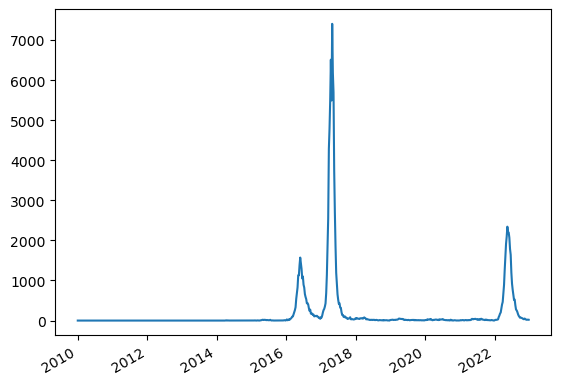

In [5]:
df_chik[f'casos_est_{CITY}'].plot()

In [6]:
INI_DATE = '2016-01-01'
END_DATE = '2022-12-25'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 52 # number of features 

Apply the dengue model:

2023-03-11 20:02:07.190662: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


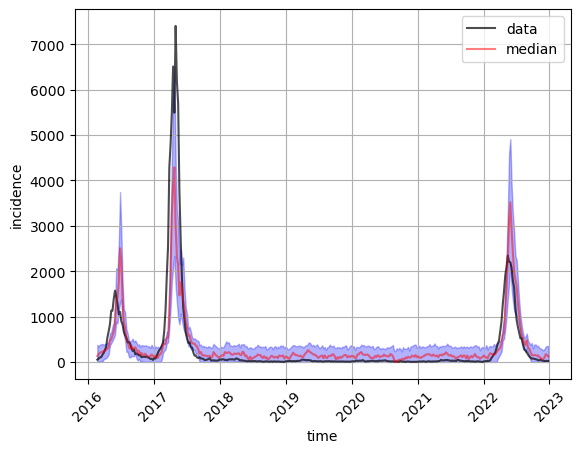

In [7]:
metrics = apply_dengue_chik(CITY, ini_date = INI_DATE, 
                         end_date = END_DATE, look_back = LOOK_BACK,
                         predict_n = PREDICT_N,  label_m = f'msle_all', filename = FILENAME_DATA  )

Applying the **transfer learning** techinique:

- Using the model trained with `loss = 'msle'`:


Compilation Time :  0.005702972412109375
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 52)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             3904      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
   

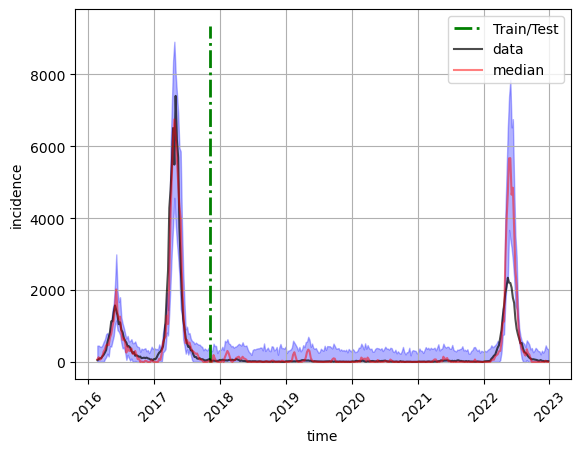

In [8]:

END_DATE_TRAIN = f'2017-11-01'

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

    
m_msle, m_t, m_val = transf_chik_pred(model, CITY, ini_date = INI_DATE, end_train_date = END_DATE_TRAIN,  
                                end_date = END_DATE, filename = f'../../saved_models/lstm/trained_{CITY}_model_msle_all.h5',  epochs= EPOCHS, features = FEAT,  
                                predict_n = PREDICT_N, look_back = LOOK_BACK, loss = 'msle' , validation_split = 0.0,
                                label = f'transf_msle', filename_data = FILENAME_DATA )

Apply the pgbm model:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


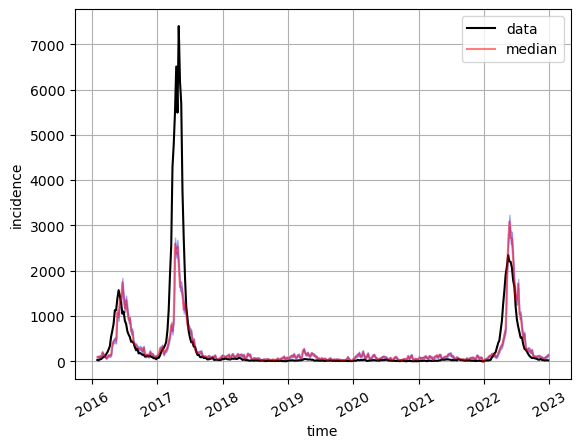

In [9]:
preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE, end_date = END_DATE, filename = FILENAME_DATA )
    